# 基于Tensorflow的softmax回归

Tensorflow是近年来非常非常流行的一个分布式的机器学习框架，之前一直想学习但是一直被各种各样的事情耽搁着。这学期恰好选了“人工神经网络”这门课，不得不接触这个框架了。最开始依照书上的教程通过Anaconda来配置环境，安装tensorflow。结果tensorflow是安装好了但是用起来是真麻烦。最后卸载了Anaconda在裸机上用`pip install tensorflow`来安装，可是裸机上的python是3.6.3版本的，似乎不支持tensorflow，于是在电脑上安装了另一个版本的python才算解决了这个问题，哎！说多了都是泪。言归正传，现在通过一个softmax实现手写字母识别的例子来正式进入tensorflow学习之旅。

softmax是一个非常常见的函数处理方式，它允许我们将模型的输出归一化并且以概率的形式输出，是非常有用的一种处理方式。具体的内容可以参见这个知乎问题[Softmax 函数的特点和作用是什么？](https://www.zhihu.com/question/23765351)

## 数据集

本例采用的是`mnist`数据集，它在机器学习领域非常有名。首先我们来认识一下这个数据集，tensorflow能够自动下载并使用这个数据集。获取到数据集之后首先查看一下训练集的大小，由于这次softmax回归使用的是mnist中的手写图片作为训练集，因此为了直观地了解一下数据集还需要查看其中的一些手写图片，在这里就用到了matplotlib这个框架来绘图。

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
训练集数据的大小为：(55000, 784)


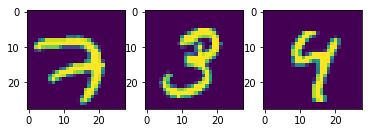

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
import os
import matplotlib.pyplot as plt
import numpy as np

os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'#禁止输出警告信息
#加载mnist数据集，one_hot设定为True是使用向量的形式编码数据类别，这主要是考虑到使用softmax
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print("训练集数据的大小为：{0}".format(mnist.train.images.shape))
fig = plt.figure("数据展示")
for k in range(3):
    result = []
    temp = []
    img = mnist.train.images[k]#获得第一幅图片，是一个28*28的图片展开成的784维的向量，
    for i in range(img.shape[0]):
        temp.append(img[i])
        if (i + 1) % 28 == 0:
            result.append(temp)
            temp = []
    img = np.matrix(result, dtype=np.float)#获取第一幅图片的矩阵形式
    ax = fig.add_subplot(130 + k + 1)
    ax.imshow(img)
plt.show()

从上面代码的输出可以看到：该数据集的训练集的规模是55000x784。数据集中每一个行向量代表着一个28x28图片的一维展开，虽然说在图片识别中像素点的位置页蕴含着非常大的信息，但是在这里就不在意那么多了，仅仅将其一维展开就可以。笔者用mat将数据集中的前三个图像画了出来展示在上面，接下来就要用到softmax回归的方法实现一个基本的首写字母识别。

## softmax回归

在这里简要介绍一下softmax回归的相关知识。softmax回归也是线性回归的一种，只不过是在输出层使用了softmax函数进行处理。具体的训练方法上也是使用了经典的随机梯度下降法训练。其判别函数有如下形式：

$$f(x)=wx+b$$

**注意：softmax回归可以用于处理多分类问题，因此上式中的所有变量都是矩阵或向量形式。**

模型的输出f(x)还并不是最终的输出，还需要用softmax函数进行处理，softmax函数的形式如下所示:

$$softmax(x)=\frac{exp(x_{i})}{\sum_{j}^{n}exp(x_{j})}$$

这样处理后的模型输出可以表达输入数据在各个标签分类上的概率表达，此外使用softmax函数还有着其他很多的好处，最主要的还是在损失函数上的便利。此处不一一列举。

softmax回归的损失函数采用信息熵的形式给出：

$$H_{y^{'}}(y)=-\sum y_{i}^{'}ln(y_{i})$$

最后，笔者想在softmax函数下推导上述损失函数的随机梯度下降法的迭代公式，虽然tensorflow为我们做了这件事，但是作为算法编写者的我们依然有必要了解这其中的细节。首先，我们需要得到损失函数关于`w`的梯度：

$$\frac{\partial H_{y^{'}}(y)}{\partial w}=\frac{\partial -\sum y_{i}^{'}ln(y_{i})}{\partial w}=\frac{\partial -yln(softmax(f(xw + b))}{\partial w}$$

该求导比较复杂，采用链式求导法：

$$\frac{\partial Loss}{\partial w}=\frac{\partial Loss}{\partial softmax(xw + b)}\frac{\partial softmax(xw + b)}{\partial xw + b}\frac{\partial xw + b}{\partial w}$$

上述链式求导就比较简单，第一项和最后一项的求导都很容易得到，关键是第二项的求导。在这里我们直接给出softmax函数的求导公式。

$$\frac{\partial softmax(xw + b)}{\partial xw + b}=softmax(xw + b)(1 - softmax(xw + b))$$

又由于上述第一项和第二项的求导为：

$$\frac{\partial Loss}{\partial softmax(xw + b)}=\frac{\partial -yln(softmax(f(xw + b))}{\partial softmax(xw + b)}=\frac{-y}{softmax(xw + b)}$$

$$\frac{\partial xw + b}{\partial w}=x$$

因此：

$$\frac{\partial -yln(softmax(f(xw + b))}{\partial w}=y(softmax(xw + b) - 1)x$$

接下来就可以使用随机梯度下降法的迭代公式来迭代求解`w`：

$$w=w+\alpha \frac{\partial -yln(softmax(f(xw + b))}{\partial w}$$

## tensroflow实现softmax回归

首先我们定义模型中的各个参数，其中x和真实的标签值y_不设定死，使用`placeholder`占据计算图的一个节点。代码如下：

In [4]:
import tensorflow as tf

session = tf.InteractiveSession()#定义一个交互式会话
x = tf.placeholder(tf.float32, [None, 784])
w = tf.Variable(tf.zeros([784, 10]))#权重w初始化为0
b = tf.Variable(tf.zeros([1, 10]))#bias初始化为0
y = tf.nn.softmax(tf.matmul(x, w) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

设定其损失函数`cross_entry`，规定优化目标，初始化全局参数：

In [5]:
cross_entry = -tf.reduce_mean(tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_set = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entry)
tf.global_variables_initializer().run()

准备工作都差不多做完了，接下来应该进行模型的训练。在本例中迭代一千次，每次从训练集中随机选取100组数据训练模型。

In [6]:
for i in range(1000):
    trainSet, trainLabel = mnist.train.next_batch(100)
    train_set.run(feed_dict={x: trainSet, y_: trainLabel})

以上，我们已经完成了模型的训练，现在应该检测一下模型的效果。我们使用mnist的测试数据来测试模型的分类效果：

In [7]:
accuracy = tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), dtype=tf.float32)
accuracy = tf.reduce_mean(accuracy)
print("模型的分类正确率为{0:.3f}".format(session.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})))

模型的分类正确率为0.917


由上面代码的输出可以看到，该例程的分类准确率还是非常高的，达到了接近92%。这篇入门介绍中用到的softmax回归其实本质上可以看作是一个无隐层的神经网络模型，只拥有一个输入层和一个输出层，二者中间使用了简单的线性方法连接。在实际的手写图片识别中可能并不会用到这样的线性模型，更多的是使用卷积神经网络（CNN）。

## 后记

这篇文章算是笔者tensorflow入门的一个小应用。说一下我对神经网络，机器学习和tensorflow的看法吧。最近这几年最热的名词可能就是人工智能，深度学习了。笔者也未能免俗，随着这股洪流加入了浩浩荡荡的机器学习大军。从最开始最简单的随机梯度下降法，线性回归到后来有些难的序列最小优化算法，支持向量机。一步步走来发现这个计算机学科的分枝还是非常有意思的，看似非常严谨，枯燥却又十分优美的数学模型竟然能够表现出一丝丝“智能”，有时候真的会惊艳到我。

从2006年起，随着计算机计算能力的快速提升，曾经被冷落的神经网络又开始热了起来。对于神经网络，个人对它的未来不是很确定，一则是因为神经网络在历史上的命运可谓是大起大落，曾经的感知机，BP都是炙手可热，却又都草草收场，谁知道这一次的AI火热是不是能持续下去，也许碰到某一个天花板就又归于沉积了呢？说到底目前的AI行业所研究的“弱人工智能”距离真正的AI还是相差甚远。都已经说不清这到底是人类技术的问题，还是哲学的问题。二则是，目前神经网络模型的可解释性太差，相较于SVM这样的模型，人们似乎说不出为什么神经网络能够表现出如此强大的分类能力。三则是，人类在AI行业的探索上总是在刻意模仿自己的大脑，在神经网络的设计中融入了很多人脑中的机制，但这真的是一条正确的路吗？人类飞上蓝天不是靠着挥舞的翅膀而是飞机的机翼。

Tensorflow是Google公司推出的一款非常流行的机器学习框架，目前看来已经占据了机器学习框架的绝对霸主地位。对于这些机器学习框架我个人的感觉是不能脱离它们自己闭门造车，但也不能过度依赖。之前笔者是排斥一切框架的，很多经典的机器学习算法都是自己编写。然而到了神经网络这一块，自己再手动编程的代价太大了，于是就不得不入了框架的坑。我的观点是：对于一个算法一定要自己将其弄懂，其中的数学推导搞清楚再看代码，用框架。切忌将模型作为一个黑箱工具来使用，虽然这在短期来看确实效率很高，但长期来看绝对是百害无一利的。学习的过程中还可以自己动手做一些小demo，提升一下编程的乐趣，还是一件非常有益的事情。